# Modelling Demand Elasticity

This example demonstrates how demand elasticity can be modelled in PyPSA, using single node capacity expansion model in the style of [model.energy](https://model.energy).

:::{note}
See [this paper by Brown, Neumann, Riepin (2024)](https://arxiv.org/abs/2407.21409) for more details.
:::

## Preparations

Loading packages, example networks and creating a utility function to retrieve price duration curve.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pypsa

plt.style.use("bmh")

In [2]:
def get_price_duration(n: pypsa.Network, bus: str = "electricity") -> pd.Series:
    s = (
        n.buses_t.marginal_price[bus]
        .sort_values(ascending=False)
        .reset_index(drop=True)
    )
    s.index = np.arange(0, 100, 100 / len(s.index))
    return s

In [3]:
# n = pypsa.examples.model_energy()
n = pypsa.Network("./model-energy.nc")
n.remove("Load", "demand")
n.remove("Generator", "load shedding")

INFO:pypsa.io:Imported network model-energy.nc has buses, carriers, generators, links, loads, storage_units, stores


## Perfectly inelastic demand

Most commonly, capacity expansion models would prescribe a perfectly inelastic demand via the `p_set` attribute, e.g. 100 MW.

The utility drawn from this consumption is effectively infinite. The model has to find a way to satisfy it. Otherwise, the model is infeasible.

In [4]:
n.add("Load", "demand", bus="electricity", p_set=100)

In [5]:
n.optimize()

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 369.41it/s]
INFO:linopy.io: Writing time: 0.44s
INFO:linopy.solvers:Log file at /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/highs.log


Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 1e+02]
Presolving model
33618 rows, 24864 cols, 89174 nonzeros  0s
30698 rows, 21944 cols, 83334 nonzeros  0s
Presolve : Reductions: rows 30698(-27708); columns 21944(-4342); elements 83334(-32050)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(225000) 0s
      16282     7.3813657701e+07 Pr: 3247(1.55927e+06); Du: 0(1.09599e-07) 5s
      21533     1.0174121738e+08 Pr: 0(0); Du: 0(7.19438e-11) 8s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 21533
Objective value     :  1.0174121738e+08
HiGHS run time      :          8.27


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26286 primals, 58406 duals
Objective: 1.02e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


Writing the solution to /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/linopy-solve-a25g8dh9.sol


('ok', 'optimal')

Market clearing prices can spike to extreme values in few hours of the year, while remaining close to zero for a majority of time.

<Axes: xlabel='Fraction of Time [%]', ylabel='Clearing Price [€/MWh]'>

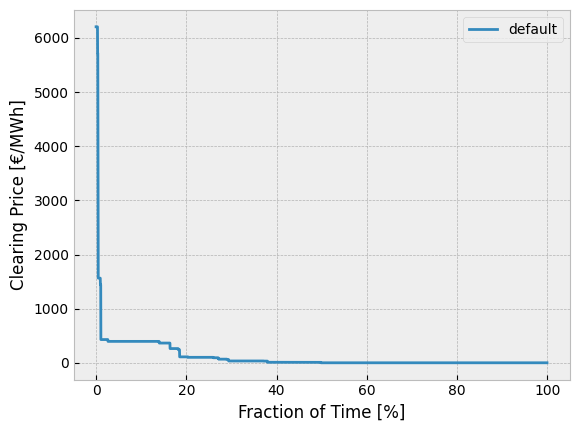

In [6]:
fig, ax = plt.subplots()
get_price_duration(n).plot(
    ax=ax,
    ylabel="Clearing Price [€/MWh]",
    xlabel="Fraction of Time [%]",
    label="default",
    legend=True,
)

In [7]:
capacities = n.statistics.optimal_capacity(round=2).to_frame("inelastic")
capacities

TypeError: StatisticsAccessor.optimal_capacity() got an unexpected keyword argument 'round'

## Perfectly inelastic demand up to VOLL

One way to avoid the price spikes is to model demand as perfectly inelastic up to a pre-defined value of lost load (VOLL).

Effectively, this is defined by a utility function $U(d) = Vd$ with a constant value $V$ for consumption $d\in[0,D]$, for instance 2000 €/MWh.

The demand curve is a step function. It is perfectly inelastic up to a price of $V$ at which point it is perfectly elastic.

When we make the substitution $d=D-g$, we see that we can model the VOLL case with a load shedding generator with marginal costs of $V=2000$ €/MWh, omitting the constant term $VD$.

$U(d) = Vd$

$U(d) = VD - Vg$

:::{note}
Note that the objective sense of PyPSA is to minimise costs in order to maximise utility, so any costs have a postive sign and utility gains have a negative sign in the objective
:::

In [ ]:
n.add(
    "Generator",
    "load-shedding",
    bus="electricity",
    carrier="load",
    marginal_cost=2000,
    p_nom=100,
)

In [ ]:
n.optimize()

Now, the peak price is capped at 2000 €/MWh:

In [ ]:
get_price_duration(n).plot(ax=ax, label="VOLL", legend=True)
fig

This results in some changes in the cost-optimal capacity mix, in particular in terms of backup capacities.

In [ ]:
capacities["VOLL"] = n.statistics.optimal_capacity(round=2)
capacities

## Linear demand curve

In reality, electricity demand is at least partially elastic. Consumers would use less electricity if its more expensive, or would use more electricity if prices are low. 

For a linear demand curve $p = a - bd$, where $p$ is the price, the utility is quadratic: $U(d) = ad - 0.5 b d^2$

For a choice of $a=2000$ and $b=20$, the demand curve looks like this:

In [ ]:
x = np.linspace(0, 100, 200)
plt.figure(figsize=(8, 4))
plt.plot(x, 2000 - 20 * x)
plt.xlabel("Demand (MW)")
plt.ylabel("Price (€/MWh)")

That means, for instance, at a price of 1000 €/MWh, the demand would be only 50 MW. At a price of 400 €/MWh, 80 MW. And so on.

Applying the same substition $d = a/b - g$ ($a/b$ yields the maximum consumption at the zero point), turns 

$U(d) = ad - 0.5 b d^2$

into 

$U(g) = \frac{a^2}{2b} - 0.5 b g^2$

which represents a load shedding generator with quadratic marginal cost $b/2$, again omitting the constant term from the objective.

Due to the quadratic terms in the objective function, this addition turns the model into a quadratic problem (QP).

In [ ]:
n.remove("Generator", "load-shedding")

n.add(
    "Generator",
    "load-shedding",
    bus="electricity",
    carrier="load",
    marginal_cost_quadratic=20 / 2,
    p_nom=100,
)

In [ ]:
n.optimize(solver_name="gurobi")

The price duration curve is considerably smoother with less extreme prices and fewer zero-price hours:

In [ ]:
get_price_duration(n).plot(ax=ax, label="linear-elastic", legend=True)
fig

Also, the optimised capacity mix is drastically different. The model cuts down on balancing technologies and rather curtails a lot demand instead. 

In [ ]:
capacities["linear-elastic"] = n.statistics.optimal_capacity(round=2)
capacities

In [ ]:
n.generators_t.p["load-shedding"].plot(figsize=(8, 2), ylabel="MW", ylim=(0, 50))

The drawback and explanation here is that the linear demand curve becomes unrealistically elastic at higher prices.

## Partial demand elasticity

It is also possible to mix different demand modelling approaches. For instance, keeping 80% of demand perfectly inelastic, while modelling 20% with a linear demand curve.

This just requires adjusting the capacity and cost terms of the load shedding generator (adjusts the slope of the linear demand curve)

In [ ]:
n.generators.loc["load-shedding", "p_nom_max"] *= 0.2
n.generators.loc["load-shedding", "marginal_cost_quadratic"] /= 0.2

In [ ]:
n.optimize(solver_name="gurobi")

The price duration curve sees a similar smoothing effect, though not as pronounced.

In [ ]:
get_price_duration(n).plot(ax=ax, label="mixed-elastic", legend=True)
fig

The optimised capacity mix returns closer to values for the VOLL case, but sees reduced storage and backup capacity as some demand curtailment is seen as economical.

In [ ]:
capacities["mixed-elastic"] = n.statistics.optimal_capacity(round=2)
capacities

The peak demand reduction is much reduced:

In [ ]:
n.generators_t.p["load-shedding"].plot(figsize=(8, 2), ylabel="MW", ylim=(0, 50))

## Piecewise-linear demand curve

It is also possible to model a set of piecewise linear demand curves, e.g. to approximate a log-log demand curve ($\ln p = a - b \ln d$), without much modification.

For details see [this paper by Brown, Neumann, Riepin (2024)](https://arxiv.org/abs/2407.21409), Section 3.2 and Appendix A. 